Import all the relevant stuff

In [1]:
# eeg analysis libraries
import mne

# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *

# numerical libraries
import numpy as np
import pandas as pd

# import tqdm for a progress bar:
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

# import file path operators
from pathlib import Path
import os

# avoid MNE being too verbose
mne.set_log_level('ERROR')

/Library/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


List all files

In [2]:
from data import raws, events

for raw in raws():
    print(raw.info['subject_info'])

{'pid': '0001', 'group': 'CTR'}
{'pid': '0025', 'group': 'CTR'}


Run preprocessing

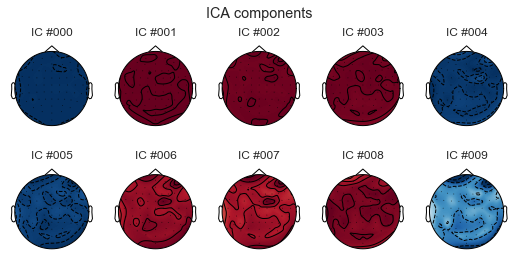

/Library/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


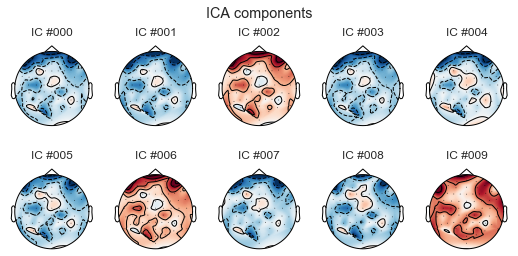

In [4]:
for raw, event in zip(raws(), events()):


    # load the raw data
    raw = raw.load_data()

    # create a new virtual channel for the VEOG and HEOG
    veog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG3', 'EXG4']), :]
    veog = np.diff(veog, axis=0)
    heog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG1', 'EXG2']), :]
    heog = np.diff(heog, axis=0)
    
    new_info = mne.create_info(['VEOG', 'HEOG'], 1024, ch_types='eog')
    raw.info['lowpass'] = new_info['lowpass'] = 1024
    
    # add these two new channels to the data
    raw = raw.add_channels(
        [mne.io.RawArray(np.concatenate([veog, heog], axis=0), new_info)]
    )
    
    # drop extra channels (not used)
    raw = raw.drop_channels(['EXG7', 'EXG8'])
    # resample the data (w/ parallel processing)
    raw = raw.resample(512, n_jobs = 6)


    # set the average of the mastoids as reference
    raw = raw.set_eeg_reference(['EXG5', 'EXG6'])
    raw = raw.apply_proj()
        
    # filter the EOG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, eeg=False, eog=True), n_jobs=6)
    # filter the EEG data (bandstop for mains and all harmonics)
    raw = raw.notch_filter(np.arange(50, raw.info['lowpass'], 50), n_jobs=6)
    
    # run an ICA to remove components correlated with both horizontal and vertical EOG traces
    seed = np.random.RandomState(2017)
    
    ica = mne.preprocessing.run_ica(raw, n_components=10, max_pca_components=60,
                                    random_state=seed, eog_ch=['HEOG', 'VEOG'],
                                    picks=mne.pick_types(raw.info, eeg=True))
    
    ica.plot_components()


Run coherence analysis on the output

In [ ]:


conn = mne.connectivity.spectral_connectivity(raw, method=['wpli', 'wpli2_debiased'], 
                                       indices=None, sfreq=6.283185307179586, 
                                       mode='multitaper', fmin=None, fmax=inf, 
                                       fskip=0, faverage=False, tmin=None, tmax=None, 
                                       mt_bandwidth=None, mt_adaptive=False, mt_low_bias=True, 
                                       cwt_frequencies=None, cwt_n_cycles=7, block_size=1000, 
                                       n_jobs=1, verbose=None)